In [65]:
import pandas as pd
import geopandas
import numpy as np
from math import pi
from matplotlib import pyplot as plt
import seaborn as sns
import common.common_pandas_lib as common

### Configuraciones librerias

In [66]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (18, 8)

sns.set(style="whitegrid", font_scale = 2) # seteando tipo de grid en seaborn
                                           # seteando tamanio de ticks label
pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

### Funciones auxiliares

In [67]:
def crear_df_porcentaje_de_caracteristica_provincias(df_reducido, caracteristica):
    df_provincias_caracteristica = df_reducido.groupby("provincia")[caracteristica].value_counts()
    df_provincias_caracteristica = df_provincias_caracteristica.to_frame()
    df_provincias_caracteristica.columns = ["cantidad"]
    df_provincias_caracteristica_porcentaje = common.crear_df_porcentaje_de_provincias(df_reducido, df_provincias_caracteristica, caracteristica).reset_index()
    df_provincias_caracteristica_porcentaje.columns = ["provincia", caracteristica, "porcentaje"]
    df_provincias_caracteristica_porcentaje = df_provincias_caracteristica_porcentaje.set_index(["provincia", caracteristica])
    return df_provincias_caracteristica_porcentaje

### Carga optimizada del set de datos

In [68]:
df = pd.read_csv('train.csv', \
       dtype = { \
                'id' : np.int32, \
                'tipodepropiedad' : 'category', \

                'ciudad' : 'category', \
                'antiguedad' : np.float16, \
                'habitaciones' : np.float16, \
                'garages' : np.float16, \
                'banos' : np.float16, \
                'metroscubiertos' : np.float16, \
                'metrostotales' : np.float16, \
                'idzona' : np.float32, \
                'gimnasio' : 'bool', \
                'usosmultiples' : 'bool', \
                'piscina' : 'bool', \
                'escuelascercanas' : 'bool', \
                'centroscomercialescercanos' : 'bool', \
                'precio' : np.float32 \
               },
        parse_dates = ['fecha'],
        date_parser = pd.to_datetime                                
    )

df = df.dropna(subset=['provincia'])

## Valores de las características

In [69]:
df = df.dropna(subset=['habitaciones'])
df = df.dropna(subset=['banos'])
df = df.dropna(subset=['garages'])

### ¿Qué valores puede tomar habitaciones?

In [70]:
habitacion_valores = df["habitaciones"].unique()
habitacion_valores.sort()
habitacion_valores

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

### ¿Qué valores puede tomar baños?

In [71]:
banos_valores = df["banos"].unique()
banos_valores.sort()
banos_valores

array([1., 2., 3., 4.])

### ¿Qué valores puede tomar garage?

In [72]:
garage_valores = df["garages"].unique()
garage_valores.sort()
garage_valores

array([0., 1., 2., 3.])

### ¿Existen diferencias notables entre las características de las 5 provincias de mayor superficie y las 5 provincias de menor superficie?

In [73]:
mexico = geopandas.read_file('Data/mexstates.shp') #Los estados pueden ser vistos con mexico.ADMIN_NAME
mexico["ADMIN_NAME"].replace({'Nuevo Leon': "Nuevo León",
                               "San Luis Potosi": "San luis Potosí",
                               "Queretaro": "Querétaro",
                               "Yucatan": "Yucatán",
                               "Michoacan": "Michoacán",
                               "Mexico": "Edo. de México",
                               "Baja California": "Baja California Norte"}, inplace=True)
mexico.Shape_Area.sum()

174.117667456488

In [74]:
def crear_porcentaje_superficie_mexico_df(df_mexico):
    provincia = []
    porcentaje = []
    area_total = df_mexico["Shape_Area"].sum()
    for index, row in df_mexico.iterrows():
        provincia.append(row["ADMIN_NAME"])
        porcentaje.append((row["Shape_Area"] * 100) / area_total)
    dic = {"provincia": provincia, "porcentaje de area": porcentaje}
    return pd.DataFrame(dic)

In [75]:
mexico = geopandas.read_file('Data/mexstates.shp') #Los estados pueden ser vistos con mexico.ADMIN_NAME

In [76]:
mexico["ADMIN_NAME"].replace({'Nuevo Leon': "Nuevo León",
                               "San Luis Potosi": "San luis Potosí",
                               "Queretaro": "Querétaro",
                               "Yucatan": "Yucatán",
                               "Michoacan": "Michoacán",
                               "Mexico": "Edo. de México",
                               "Baja California": "Baja California Norte"}, inplace=True)

In [77]:
porcentaje_area_mexico = crear_porcentaje_superficie_mexico_df(mexico)
porcentaje_area_mexico = porcentaje_area_mexico.sort_values("porcentaje de area")
porcentaje_area_mexico

,provincia,porcentaje de area
22,Distrito Federal,0.07
20,Tlaxcala,0.20
23,Morelos,0.25
9,Aguascalientes,0.28
21,Colima,0.28
12,Querétaro,0.60
15,Hidalgo,1.06
19,Edo. de México,1.07
26,Tabasco,1.18
31,Nayarit,1.38


In [78]:
provincias_areas_mayores = porcentaje_area_mexico.nlargest(6, "porcentaje de area")
categorias = ["habitaciones", "banos", "garages"]
provincias_mas_grandes = list(provincias_areas_mayores["provincia"])
provincias_mas_grandes_df = df[df["provincia"].isin(list(provincias_areas_mayores["provincia"]))]
provincias_mas_grandes_df = provincias_mas_grandes_df.groupby("provincia")[categorias].mean()
provincias_mas_grandes_df = provincias_mas_grandes_df.reset_index()
provincias_mas_grandes_df = provincias_mas_grandes_df.merge(provincias_areas_mayores, how = "inner")
provincias_mas_grandes_df = provincias_mas_grandes_df.sort_values("porcentaje de area", ascending = False)

In [79]:
provincias_mas_grandes_df = provincias_mas_grandes_df.drop("porcentaje de area", axis=1)
provincias_mas_grandes_df = provincias_mas_grandes_df.set_index("provincia")

In [80]:
provincias_areas_menores = porcentaje_area_mexico.nsmallest(6, "porcentaje de area")
categorias = ["habitaciones", "banos", "garages"]
provincias_mas_chicas = list(provincias_areas_menores["provincia"])
provincias_mas_chicas_df = df[df["provincia"].isin(list(provincias_areas_menores["provincia"]))]
provincias_mas_chicas_df = provincias_mas_chicas_df.groupby("provincia")[categorias].mean()
provincias_mas_chicas_df = provincias_mas_chicas_df.reset_index()
provincias_mas_chicas_df = provincias_mas_chicas_df.merge(provincias_areas_menores, how = "inner")
provincias_mas_chicas_df = provincias_mas_chicas_df.sort_values("porcentaje de area")

In [81]:
provincias_mas_chicas_df = provincias_mas_chicas_df.drop("porcentaje de area", axis=1)
provincias_mas_chicas_df = provincias_mas_chicas_df.set_index("provincia")

### Provincias de mayor superficie de Mexico

<Figure size 1800x800 with 0 Axes>

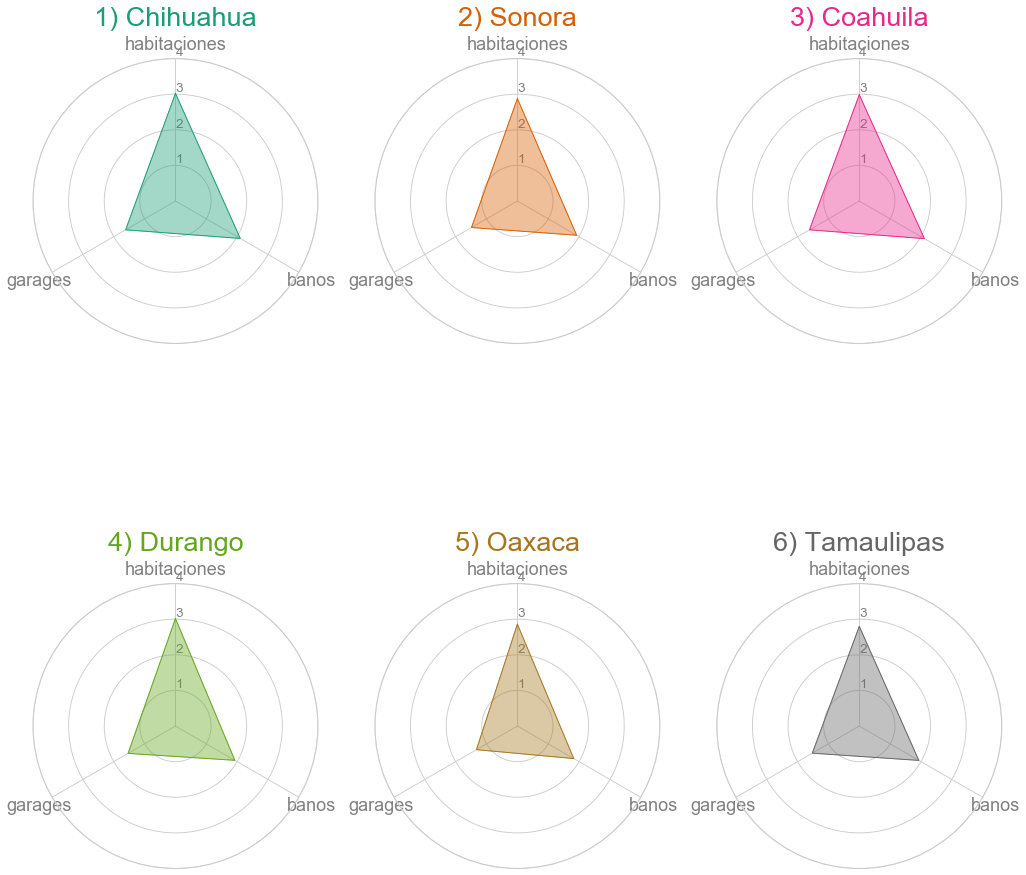

<Figure size 1800x800 with 0 Axes>

In [82]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
common.crear_radares_alineados(provincias_mas_grandes_df.reset_index(), 2, 3, "Dark2")

### Provincias de menor superficie de Mexico

<Figure size 1800x800 with 0 Axes>

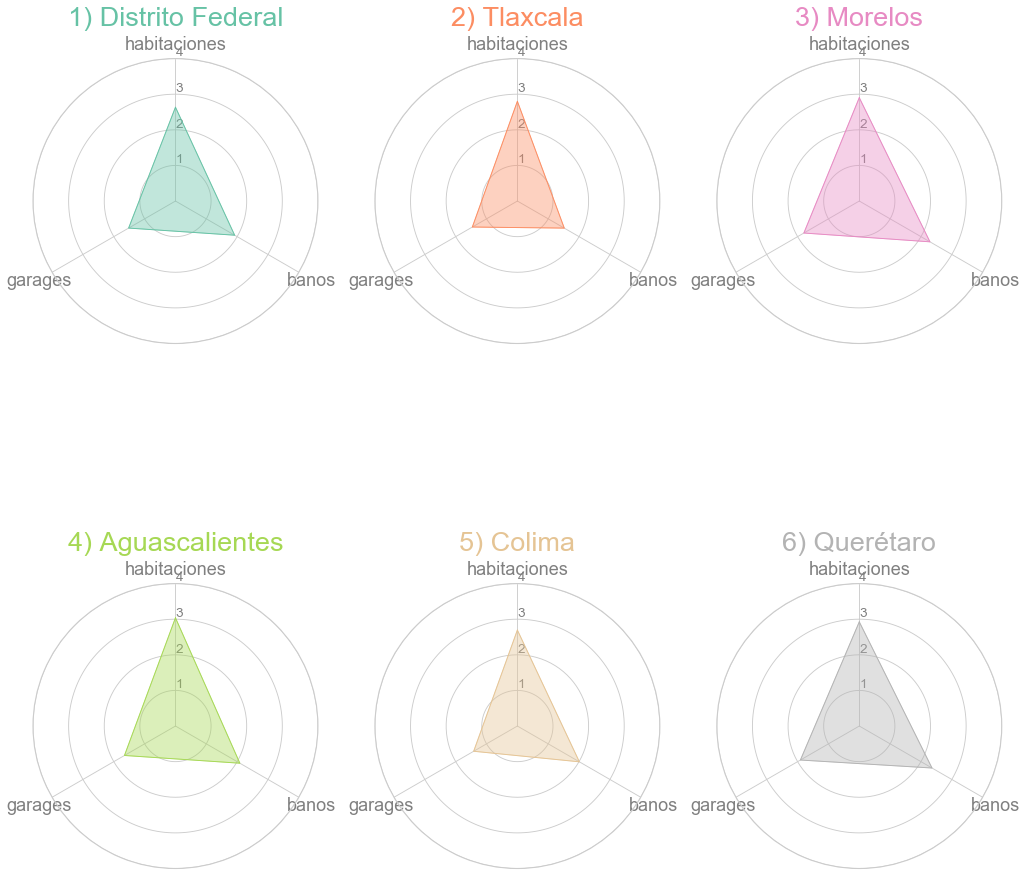

<Figure size 1800x800 with 0 Axes>

In [83]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
common.crear_radares_alineados(provincias_mas_chicas_df.reset_index(), 2, 3, "Set2")

### ¿Todas las provincias poseen una misma distribución de cantidades habitaciones? ¿Son 3 baños los que más abundan en relación a los otros?

In [84]:
df

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,nan,2.00,1.00,...,"23,533.00",nan,nan,2015-08-23,False,False,False,False,False,"2,273,000.00"
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.00,3.00,2.00,...,"24,514.00",19.31,-99.23,2013-06-28,False,False,False,True,True,"3,600,000.00"
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.00,3.00,2.00,...,"48,551.00",nan,nan,2015-10-17,False,False,False,False,False,"1,200,000.00"
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.00,2.00,1.00,...,"53,666.00",19.30,-99.69,2012-03-09,False,False,False,True,True,"650,000.00"
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.00,2.00,1.00,...,"47,835.00",nan,nan,2016-06-07,False,False,False,False,False,"1,150,000.00"
5,126147,departamento en venta taxqueña,"amplio departamento, estancia de sala y comedo...",Apartamento,Condominio Tlalpan 2B,Coyoacán,Distrito Federal,5.00,2.00,1.00,...,"23,650.00",19.30,-99.15,2014-03-18,False,False,False,False,True,"1,100,000.00"
6,139233,de oportunidad casa en san lorenzo,"ubicada en esquina, pertenece san lorenzo agen...",Casa,NaN,Oaxaca de Juárez,Oaxaca,nan,3.00,1.00,...,"73,510.00",17.14,-96.80,2016-02-23,False,False,False,False,False,"1,150,000.00"
7,5013,casa emilia en venta en selvamar playa del carmen,casa emilia en venta playa del carmenfracciona...,Casa,condominio el trebol,Playa del Carmen,Quintana Roo,2.00,4.00,2.00,...,"130,510.00",20.67,-87.04,2016-10-20,False,False,False,False,False,"4,200,000.00"
8,44962,pre- venta preciosos depas 2 recamaras con sub...,<p>pre-venta de preciosos departamento ecologi...,Apartamento,BUENAVISTA DEPTOS CON SUBSIDIO,Villa de Alvarez,Colima,1.00,2.00,1.00,...,"9,010.00",nan,nan,2014-01-06,False,False,False,True,True,"310,000.00"
10,51180,mi 2° credito,<p>mi 2&deg; credito<br />para todos aquellos ...,Casa,MI 2° CREDITO,San Luis Potosí,San luis Potosí,0.00,3.00,1.00,...,"87,542.00",22.20,-101.02,2013-01-03,False,False,False,True,True,"488,000.00"


### Promedio de habitaciones por provincia

In [85]:
provincia_habitaciones_promedio = df.groupby("provincia")["habitaciones"].mean()

(<Figure size 1000x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2f92333db38>)

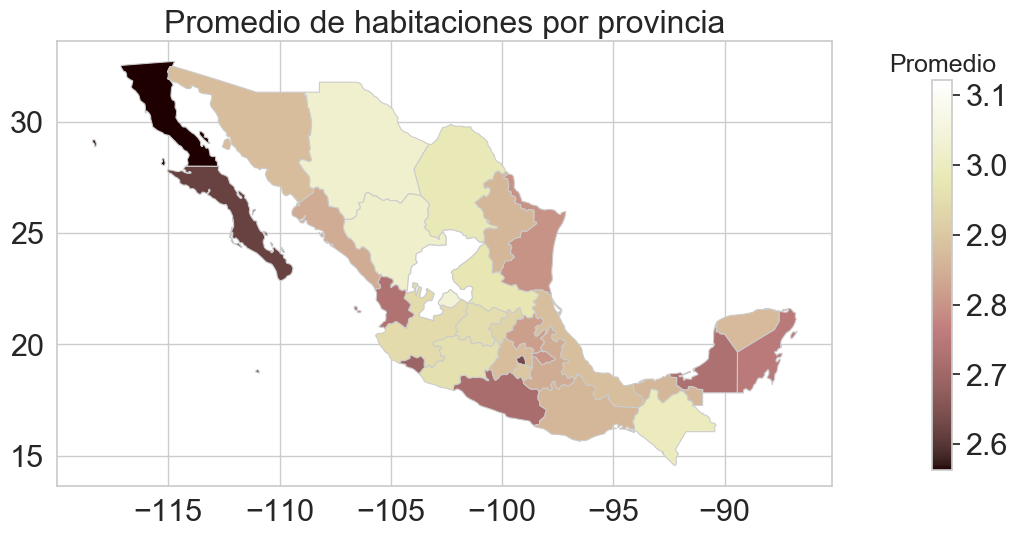

<Figure size 1250x1250 with 0 Axes>

In [86]:
common.crear_mapa(provincia_habitaciones_promedio, "habitaciones", provincia_habitaciones_promedio.min(), provincia_habitaciones_promedio.max(), "Promedio de habitaciones por provincia", "Promedio", "pink")

### Promedio de baños por provincia

In [87]:
provincia_banos_promedio = df.groupby("provincia")["banos"].mean()

(<Figure size 1000x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2f90c699828>)

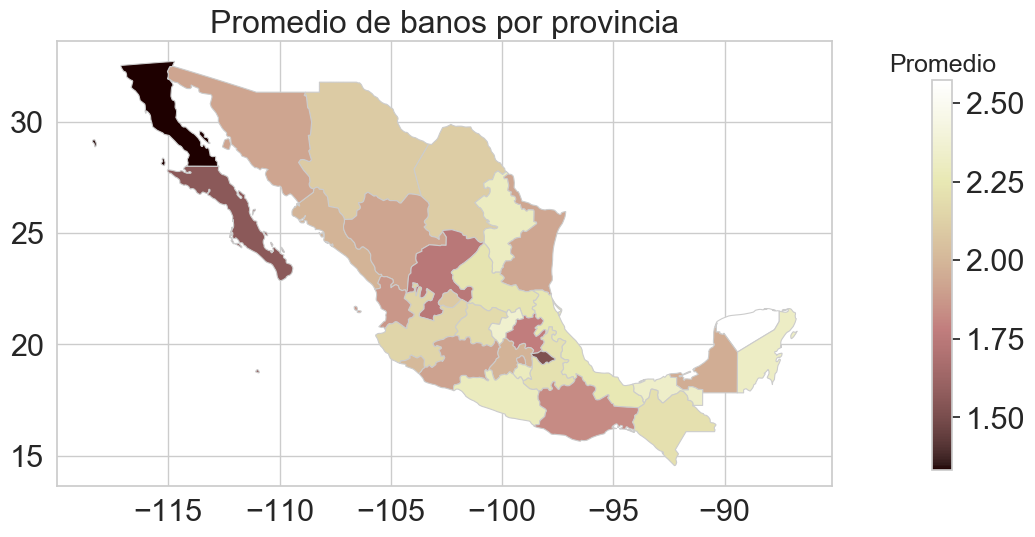

<Figure size 1250x1250 with 0 Axes>

In [88]:
common.crear_mapa(provincia_banos_promedio, "banos", provincia_banos_promedio.min(),
           provincia_banos_promedio.max(), "Promedio de banos por provincia", "Promedio", "pink")

### Promedio de garages por provincia

In [89]:
provincia_garage_promedio = df.groupby("provincia")["garages"].mean()

(<Figure size 1000x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2f92e845c50>)

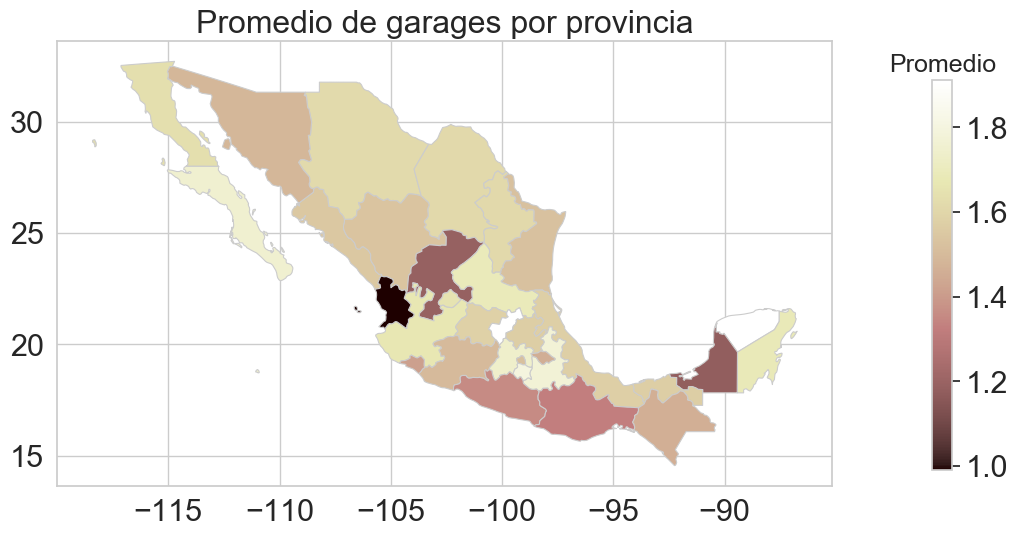

<Figure size 1250x1250 with 0 Axes>

In [90]:
common.crear_mapa(provincia_garage_promedio, "garages", provincia_garage_promedio.min(),
           provincia_garage_promedio.max(), "Promedio de garages por provincia", "Promedio", "pink")

### ¿Existe un patrón en las características de las provincias con más cantidad de propiedades?

In [91]:
provincias_cantidad_propiedades = df["provincia"].value_counts()
provincias_mas_propiedades = provincias_cantidad_propiedades.nlargest(6)
provincias_mas_propiedades = list(provincias_mas_propiedades.index)

categorias = ["habitaciones", "banos", "garages"]
provincias_mas_propiedades = df[df["provincia"].isin(list(provincias_mas_propiedades))]
provincias_mas_propiedades = provincias_mas_propiedades.groupby("provincia")[categorias].mean()
provincias_mas_propiedades

,habitaciones,banos,garages
provincia,,,
Distrito Federal,2.63,1.92,1.52
Edo. de México,2.88,1.98,1.74
Jalisco,2.95,2.15,1.67
Nuevo León,2.86,2.30,1.61
Puebla,2.84,2.21,1.77
Querétaro,2.93,2.36,1.91


<Figure size 1800x800 with 0 Axes>

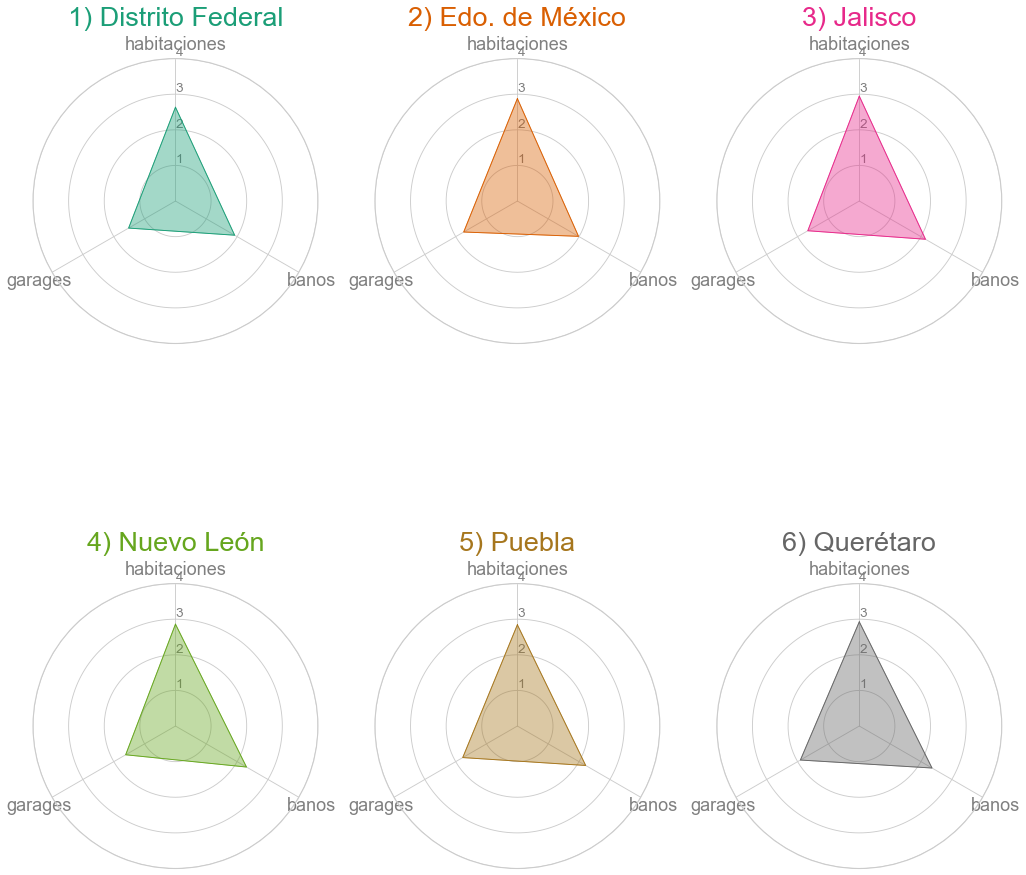

<Figure size 1800x800 with 0 Axes>

In [92]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
common.crear_radares_alineados(provincias_mas_propiedades.reset_index(), 2, 3, "Dark2")

### Distribución de habitaciones:

In [93]:
#Elimino las provs con menos de 3000
provincias_validas = df["provincia"].value_counts() > 3000
provincias_validas = provincias_validas[provincias_validas == True]
provincias_validas = list(provincias_validas.index)
df_reducido = df[df["provincia"].isin(provincias_validas)]

In [94]:
df_provincias_habitaciones_porcentaje = crear_df_porcentaje_de_caracteristica_provincias(df_reducido, "habitaciones")

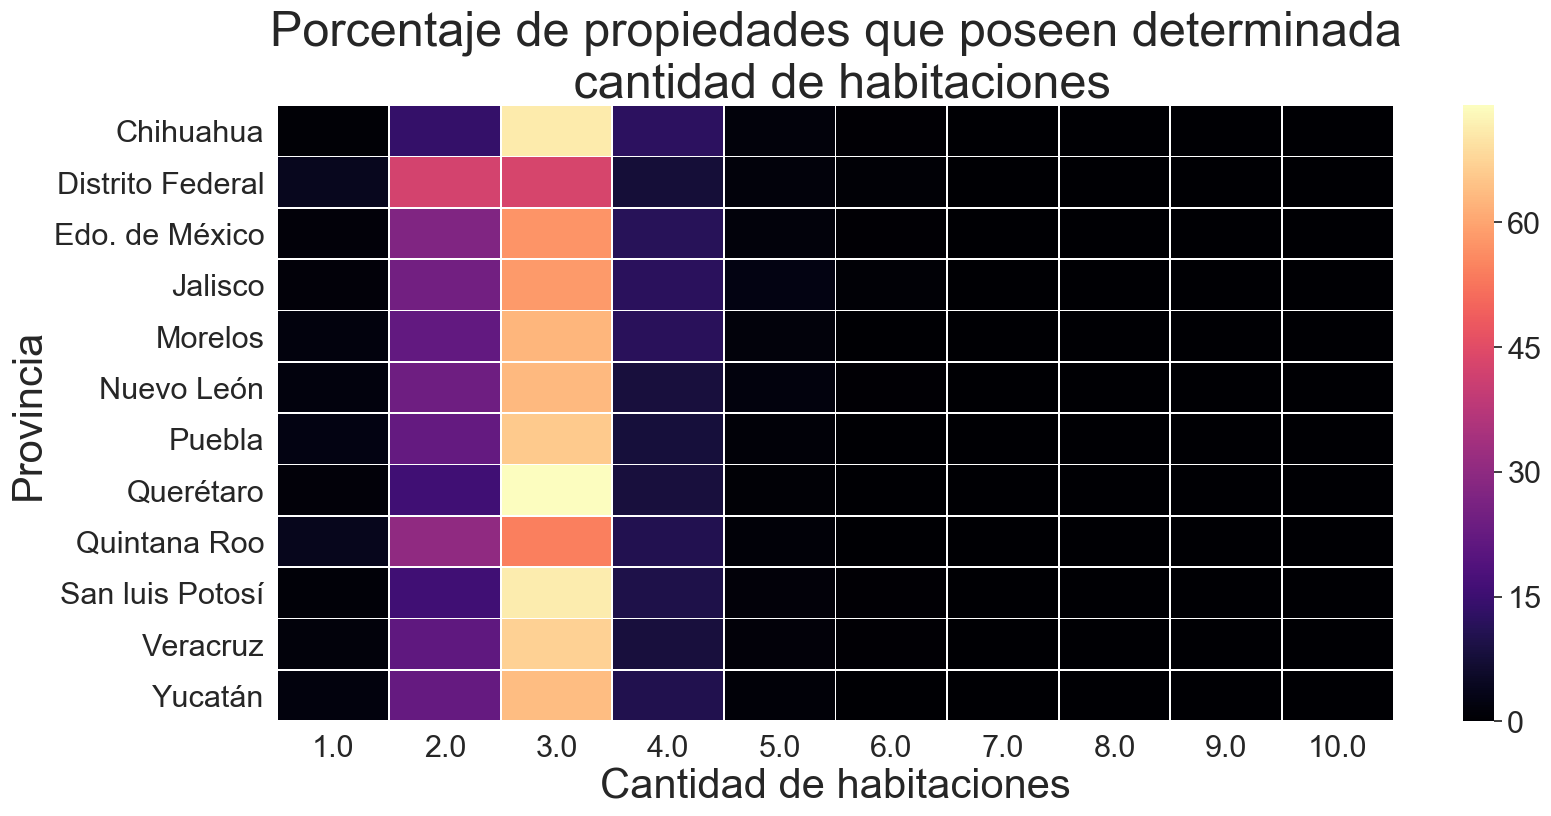

In [95]:
common.crear_heatmap_porcentaje(df_provincias_habitaciones_porcentaje, "habitaciones", "Porcentaje de propiedades que poseen determinada\n cantidad de habitaciones", "Cantidad de habitaciones", "Provincia", "magma")

### Distribución de baños:

In [96]:
df_provincias_banos_porcentaje = crear_df_porcentaje_de_caracteristica_provincias(df_reducido, "banos")

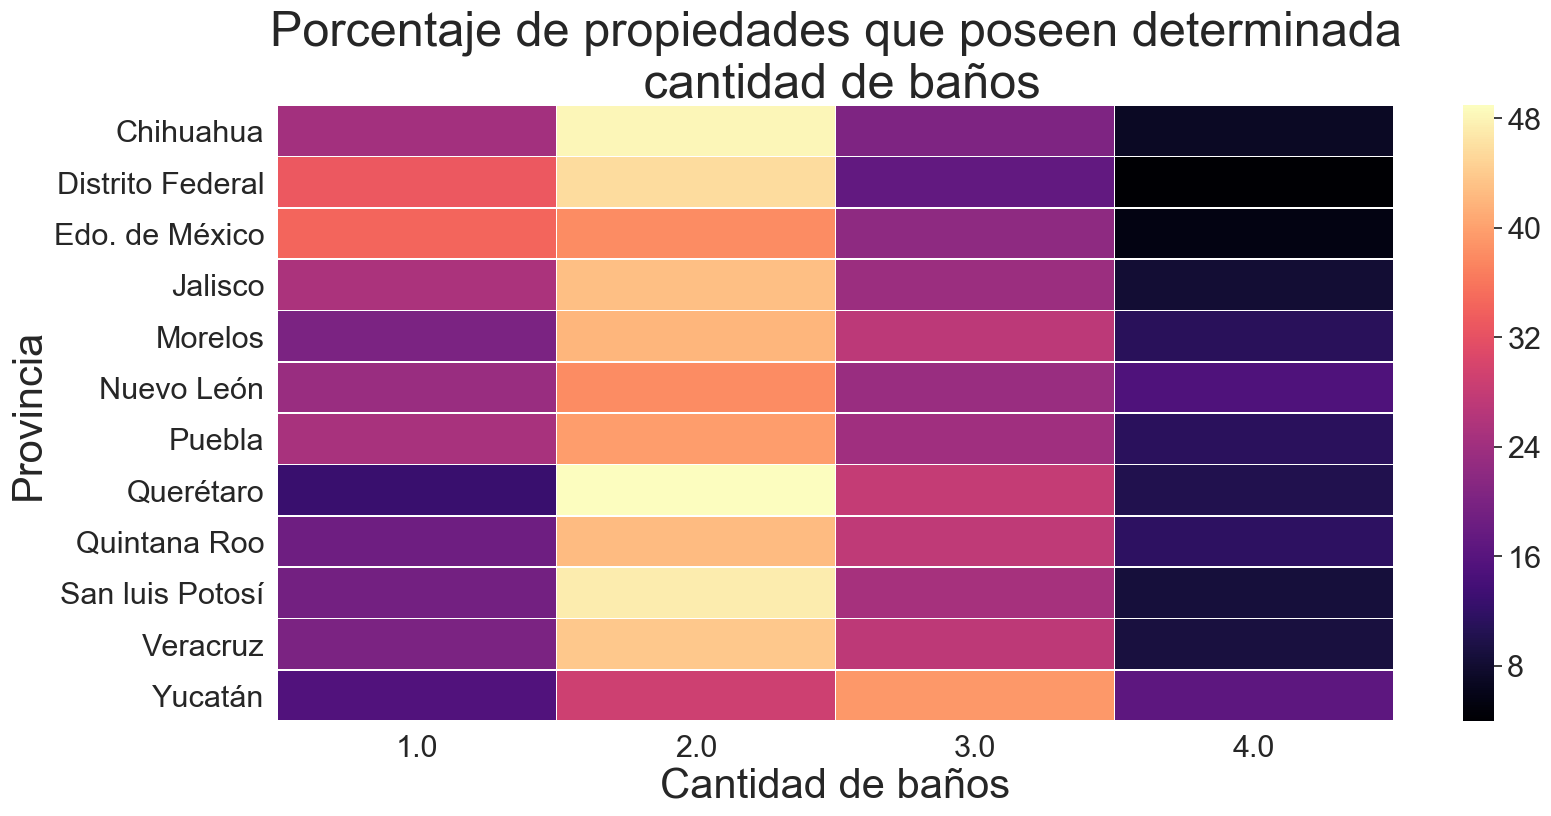

In [97]:
common.crear_heatmap_porcentaje(df_provincias_banos_porcentaje, "banos","Porcentaje de propiedades que poseen determinada\n cantidad de baños", "Cantidad de baños", "Provincia", "magma")

### Distribución de garages

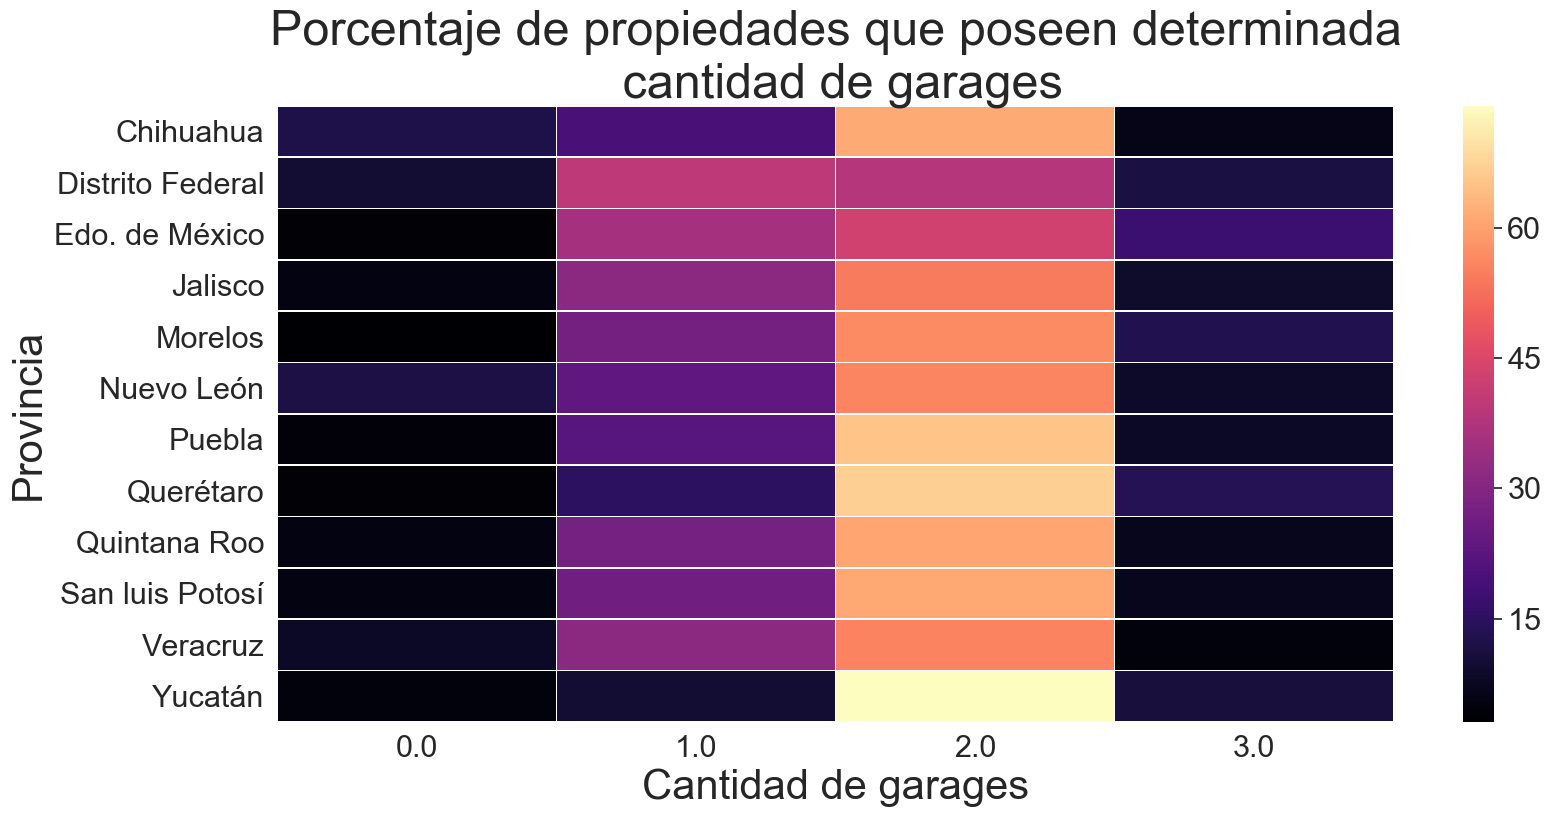

In [98]:
df_provincias_banos_porcentaje = crear_df_porcentaje_de_caracteristica_provincias(df_reducido, "garages")
common.crear_heatmap_porcentaje(df_provincias_banos_porcentaje, "garages","Porcentaje de propiedades que poseen determinada\n cantidad de garages", "Cantidad de garages", "Provincia", "magma")